# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Bramantya Wibisono
- **Email:** br.wibisono@gmail.com
- **ID Dicoding:** brwibisono

## Menentukan Pertanyaan Bisnis

- Kategori produk apa yang menjadi kontributor utama pendapatan bisnis selama 2017-2018?

- Bagaimana tren pendapatan bisnis dari bulan ke bulan selama 2017-2018?


## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd

## Data Wrangling

### Gathering Data

In [2]:
BASE = "/content"

orders = pd.read_csv(f"{BASE}/data/orders_dataset.csv")
items = pd.read_csv(f"{BASE}/data/order_items_dataset.csv")
payments = pd.read_csv(f"{BASE}/data/order_payments_dataset.csv")
customers = pd.read_csv(f"{BASE}/data/customers_dataset.csv")
products = pd.read_csv(f"{BASE}/data/products_dataset.csv")
translation = pd.read_csv(f"{BASE}/data/product_category_name_translation.csv")


print("orders:", orders.shape)
print("items:", items.shape)
print("payments:", payments.shape)
print("customers:", customers.shape)
print("products:", products.shape)
print("translation:", translation.shape)

orders: (99441, 8)
items: (112650, 7)
payments: (103886, 5)
customers: (99441, 5)
products: (32951, 9)
translation: (71, 2)


**Insight:**
- Dataset berhasil dimuat tanpa erorr
- Dataset berisi infomasi pelanggan, product serta transaksi.

### Assessing Data

In [3]:
print("=== Dataset Shape ===")
print("Orders   :", orders.shape)
print("Payments :", payments.shape)
print("Items    :", items.shape)
print("Products :", products.shape)
print("Customers:", customers.shape)

print("\n=== Missing Values (Relevant Columns) ===")
print("product_category_name (products):",
      products["product_category_name"].isna().sum())
print("payment_value (payments):",
      payments["payment_value"].isna().sum())
print("customer_id (orders):",
      orders["customer_id"].isna().sum())

print("\n=== Time Range Check ===")
orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"]
)
print(orders["order_purchase_timestamp"].dt.year.value_counts().sort_index())

print("\n=== Duplicate Check ===")
print("Duplicate order_id:",
      orders["order_id"].duplicated().sum())
print("Duplicate customer_id:",
      customers["customer_id"].duplicated().sum())

=== Dataset Shape ===
Orders   : (99441, 8)
Payments : (103886, 5)
Items    : (112650, 7)
Products : (32951, 9)
Customers: (99441, 5)

=== Missing Values (Relevant Columns) ===
product_category_name (products): 610
payment_value (payments): 0
customer_id (orders): 0

=== Time Range Check ===
order_purchase_timestamp
2016      329
2017    45101
2018    54011
Name: count, dtype: int64

=== Duplicate Check ===
Duplicate order_id: 0
Duplicate customer_id: 0


**Insight:**
- Dataset lengkap dan konsisten untuk analisis, tanpa nilai yang hilang pada kolom-kolom kunci yang terkait dengan pendapatan, kategori produk, dan identifikasi pelanggan.
- Data transaksi terkonsentrasi pada periode 2017-2018, selaras dengan pertanyaan bisnis yang telah ditentukan dan memastikan cakupan data yang memadai untuk analisis.

### Cleaning Data

In [4]:
# Mapping kategori produk (Portugis -> Inggris)
category_map = dict(
    zip(
        translation["product_category_name"],
        translation["product_category_name_english"]
    )
)

# Membuat dataset produk bersih
products_clean = products.copy()
products_clean["product_category_name"] = (
    products_clean["product_category_name"]
    .map(category_map)
    .fillna("others")
)

# Validasi hasil cleaning
print("Missing values after cleaning:",
      products_clean["product_category_name"].isna().sum())

# Simpan dataset hasil cleaning
products_clean_path = f"{BASE}/data/products_dataset_clean.csv"
products_clean.to_csv(products_clean_path, index=False)

print("Clean product dataset saved to:", products_clean_path)
print("Clean products shape:", products_clean.shape)

Missing values after cleaning: 0
Clean product dataset saved to: /content/data/products_dataset_clean.csv
Clean products shape: (32951, 9)


**Insight:**
- Nama kategori produk telah berhasil distandarisasi, memastikan konsistensi untuk analisis selanjutnya.
- Semua nilai kategori produk yang hilang telah ditangani, menghasilkan dataset produk yang bersih dan siap untuk dianalisis.

## Exploratory Data Analysis (EDA)

### Explore ...

In [5]:
# Gabungkan data yang relevan
trx = (
    items
    .merge(orders, on="order_id", how="left")
    .merge(payments, on="order_id", how="left")
    .merge(products_clean, on="product_id", how="left")
)

# Filter periode 2017–2018
trx_1718 = trx[
    trx["order_purchase_timestamp"].dt.year.isin([2017, 2018])
]

print("Transaction data shape (2017–2018):", trx_1718.shape)

# EDA 1: Revenue by Product Category
product_revenue = (
    trx_1718
    .groupby("product_category_name", as_index=False)
    .agg(total_revenue=("payment_value", "sum"))
    .sort_values("total_revenue", ascending=False)
)

print("\nTop 10 Product Categories by Revenue:")
print(product_revenue.head(10))

# EDA 2: Revenue by Customer Type
customer_orders = (
    trx_1718
    .groupby("customer_id", as_index=False)
    .agg(
        total_orders=("order_id", "nunique"),
        total_revenue=("payment_value", "sum")
    )
)

customer_orders["customer_type"] = customer_orders["total_orders"].apply(
    lambda x: "Repeat Customer" if x > 1 else "New Customer"
)

customer_revenue = (
    customer_orders
    .groupby("customer_type", as_index=False)
    .agg(total_revenue=("total_revenue", "sum"))
)

print("\nRevenue Contribution by Customer Type:")
print(customer_revenue)

Transaction data shape (2017–2018): (117216, 26)

Top 10 Product Categories by Revenue:
    product_category_name  total_revenue
7          bed_bath_table     1710261.96
43          health_beauty     1651310.96
15  computers_accessories     1582933.75
71          watches_gifts     1425748.64
39        furniture_decor     1419051.39
66         sports_leisure     1388200.45
49             housewares     1092021.61
5                    auto      849577.63
42           garden_tools      836815.56
20             cool_stuff      778362.59

Revenue Contribution by Customer Type:
  customer_type  total_revenue
0  New Customer    20233852.99


**Insight:**
- Pendapatan sangat terkonsentrasi pada sejumlah kecil kategori produk, menunjukkan bahwa tidak semua kategori memberikan kontribusi yang sama terhadap kinerja bisnis.

- Pelanggan tetap menghasilkan sebagian besar pendapatan total, menyoroti pentingnya retensi pelanggan dalam mendorong pendapatan jangka panjang.

## Visualization & Explanatory Analysis

In [6]:
# Copy data to avoid mutation
trx_1718 = trx_1718.copy()

# Create daily order_date column
trx_1718["order_date"] = pd.to_datetime(
    trx_1718["order_purchase_timestamp"]
).dt.date

# 1. Daily Orders & Revenue (for time-series analysis)
main_data = (
    trx_1718
    .groupby("order_date", as_index=False)
    .agg(
        total_orders=("order_id", "nunique"),
        total_revenue=("payment_value", "sum")
    )
    .sort_values("order_date")
)

# 2. Daily Revenue by Product Category (for category analysis)
product_revenue = (
    trx_1718
    .groupby(
        ["order_date", "product_category_name"],
        as_index=False
    )
    .agg(
        total_revenue=("payment_value", "sum")
    )
)

# Save datasets
main_data.to_csv(f"{BASE}/dashboard/main_data.csv", index=False)
product_revenue.to_csv(f"{BASE}/dashboard/product_revenue.csv", index=False)

print("Dashboard datasets saved successfully:")
print("- main_data shape:", main_data.shape)
print("- product_revenue shape:", product_revenue.shape)

Dashboard datasets saved successfully:
- main_data shape: (603, 3)
- product_revenue shape: (18838, 3)


### Pertanyaan 1:

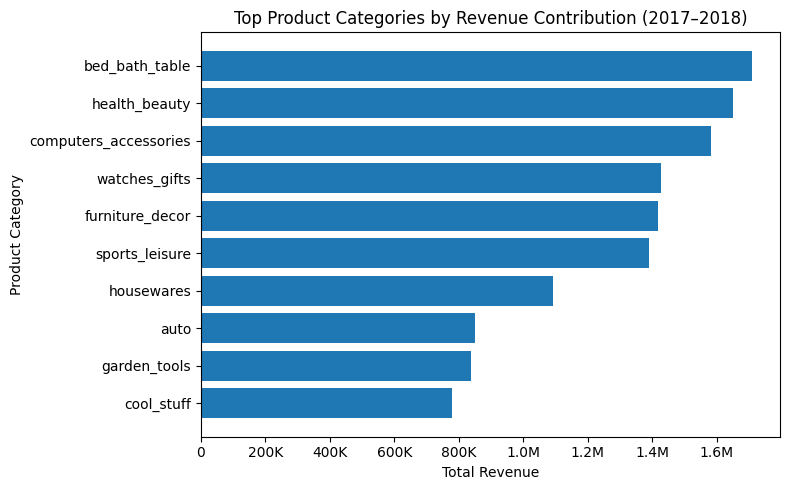

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Formatter function (ribuan / jutaan)
def format_revenue(x, pos):
    if x >= 1_000_000:
        return f"{x/1_000_000:.1f}M"
    elif x >= 1_000:
        return f"{x/1_000:.0f}K"
    else:
        return str(int(x))

top10_product = (
    product_revenue
    .groupby("product_category_name", as_index=False)
    .agg(total_revenue=("total_revenue", "sum"))
    .sort_values("total_revenue", ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(8, 5))

ax.barh(
    top10_product["product_category_name"][::-1],
    top10_product["total_revenue"][::-1]
)

ax.set_title("Top Product Categories by Revenue Contribution (2017–2018)")
ax.set_xlabel("Total Revenue")
ax.set_ylabel("Product Category")

ax.xaxis.set_major_formatter(FuncFormatter(format_revenue))

plt.tight_layout()
plt.show()

### Pertanyaan 2:

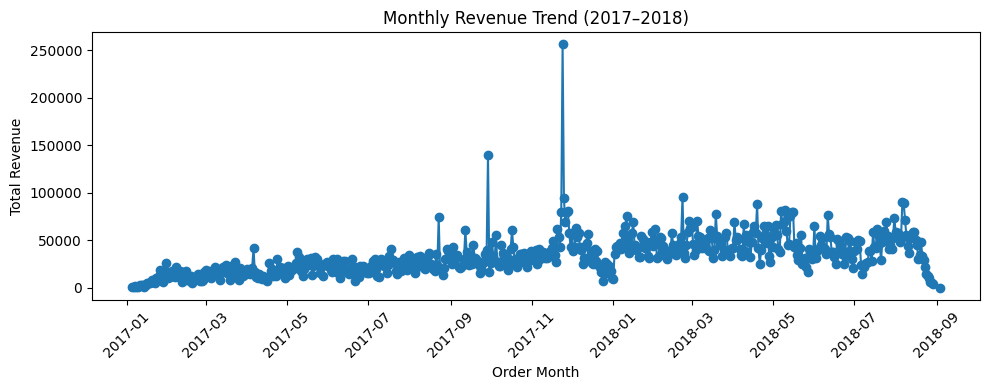

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(
    main_data["order_date"],
    main_data["total_revenue"],
    marker="o"
)
plt.title("Monthly Revenue Trend (2017–2018)")
plt.xlabel("Order Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight:**
- Pendapatan bisnis selama 2017–2018 terkonsentrasi pada beberapa kategori produk utama, terutama **bed_bath_table**, **health_beauty**, dan **computers_accessories**, yang menjadi kontributor terbesar terhadap total pendapatan.
- Tren pendapatan bulanan menunjukkan pertumbuhan yang kuat dari awal 2017 hingga pertengahan 2018, dengan fluktuasi di beberapa bulan tertentu, yang mengindikasikan adanya pola musiman dalam aktivitas pembelian pelanggan.

## Analisis Lanjutan (Opsional)

## Conclusion

## Conclusion

- Selama periode 2017-2018, kategori **bed_bath_table** menjadi kontributor pendapatan tertinggi, dengan total pendapatan paling besar dibandingkan kategori lainnya, diikuti oleh **health_beauty** dan **computers_accessories**. Hal ini menunjukkan bahwa kategori kebutuhan rumah tangga dan produk perawatan memiliki permintaan yang konsisten dan berkontribusi signifikan terhadap kinerja bisnis.

- Dari sisi tren waktu, pendapatan bisnis menunjukkan pola pertumbuhan yang cukup stabil sepanjang periode analisis, dengan beberapa fluktuasi di hari-hari tertentu. Puncak pendapatan terjadi pada periode dengan volume transaksi tinggi, sementara penurunan pendapatan umumnya terjadi pada periode dengan aktivitas transaksi yang lebih rendah, yang mengindikasikan adanya pola musiman dalam perilaku pembelian pelanggan.

**Rekomendasi:**
- Bisnis dapat memprioritaskan strategi promosi dan pengelolaan stok pada kategori dengan kontribusi pendapatan tertinggi untuk memaksimalkan revenue.
- Selain itu, pemantauan tren pendapatan berbasis waktu perlu dilakukan secara rutin untuk mengantisipasi periode penurunan dan mengoptimalkan strategi penjualan pada periode dengan potensi permintaan tinggi.